# **[CAR EVALUATION](https://archive.ics.uci.edu/dataset/19/car+evaluation) 🚗**

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow import keras
from tensorflow.keras import layers

### Carga de datos

In [3]:
col_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv("car+evaluation/car.data", header=None, names=col_names)

In [5]:
df.head(5)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


### Split

In [6]:
X = df.drop(columns=["class"])
y = df["class"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


### One-Hot Features

In [7]:
cat_features = list(X.columns)
preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)]
)
preprocess.fit(X_train)
X_train_ohe = preprocess.transform(X_train)
X_val_ohe   = preprocess.transform(X_val)
X_test_ohe  = preprocess.transform(X_test)


In [8]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
n_classes   = len(le.classes_)

### Train

In [9]:
rng = np.random.default_rng(7)
unique, counts = np.unique(y_train_enc, return_counts=True)
max_count = counts.max()

Xb_list, yb_list = [], []
for cls, cnt in zip(unique, counts):
    idx = np.where(y_train_enc == cls)[0]
    Xc, yc = X_train_ohe[idx], y_train_enc[idx]
    if cnt < max_count:
        add_idx = rng.choice(idx, size=max_count - cnt, replace=True)
        Xc = np.vstack([Xc, X_train_ohe[add_idx]])
        yc = np.concatenate([yc, y_train_enc[add_idx]])
    Xb_list.append(Xc); yb_list.append(yc)

X_train_bal = np.vstack(Xb_list)
y_train_bal = np.concatenate(yb_list)
shuf = rng.permutation(len(y_train_bal))
X_train_bal = X_train_bal[shuf]; y_train_bal = y_train_bal[shuf]

# 6) Modelo Keras
model = keras.Sequential([
    layers.Input(shape=(X_train_ohe.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=7e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
hist = model.fit(X_train_bal, y_train_bal,
                 validation_data=(X_val_ohe, y_val_enc),
                 epochs=200, batch_size=32, callbacks=[es], verbose=0)


### Evaluacion

Test Accuracy: 1.0
Macro Precision: 1.0 Macro Recall: 1.0 Macro F1: 1.0

Classification report:
               precision    recall  f1-score   support

         acc       1.00      1.00      1.00        77
        good       1.00      1.00      1.00        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346



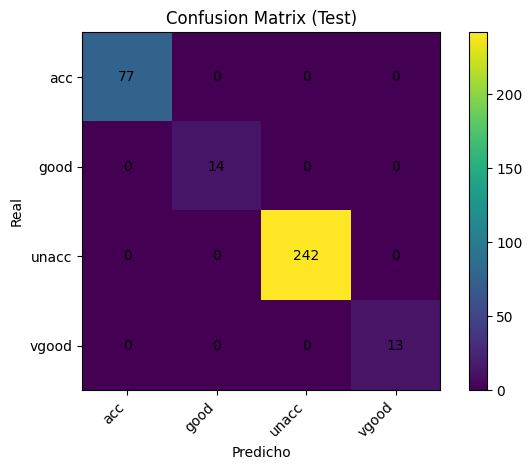

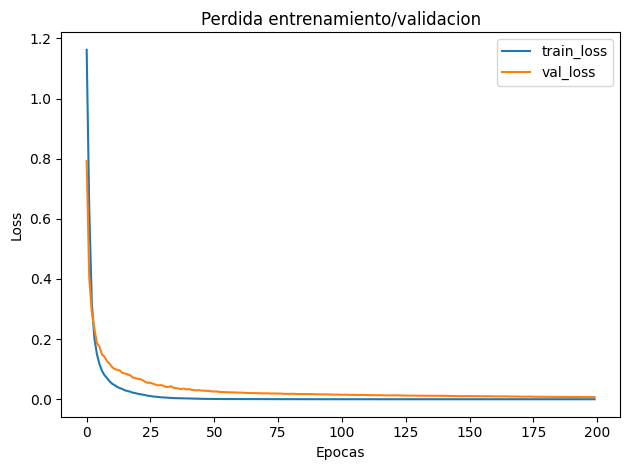

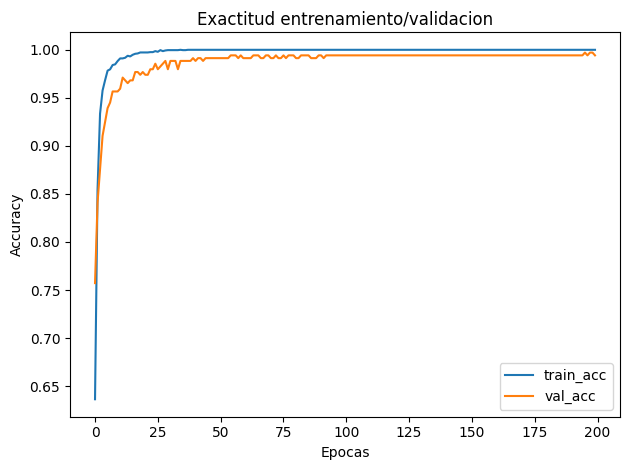

In [11]:
y_pred_test = np.argmax(model.predict(X_test_ohe, verbose=0), axis=1)
acc = accuracy_score(y_test_enc, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_enc, y_pred_test, average="macro", zero_division=0)
print("Test Accuracy:", acc)
print("Macro Precision:", prec, "Macro Recall:", rec, "Macro F1:", f1)

print("\nClassification report:\n", classification_report(y_test_enc, y_pred_test, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test_enc, y_pred_test)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xticks(np.arange(n_classes), le.classes_, rotation=45, ha="right")
plt.yticks(np.arange(n_classes), le.classes_)
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.colorbar()
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# Curvas de entrenamiento
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("Perdida entrenamiento/validacion")
plt.xlabel("Epocas"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Exactitud entrenamiento/validacion")
plt.xlabel("Epocas"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()